In [58]:
import pandas as pd
import os
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sqlalchemy import create_engine, Text, String, Float
from sqlalchemy.sql import text
from dotenv import load_dotenv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
from plotly.subplots import make_subplots

load_dotenv()

CONFIG ={
    "git_token":os.getenv("GIT_TOKEN"),
    "kipris_key":os.getenv("KIPRIS_KEY"),
    "rds_user":os.getenv("DB_USER"),
    "rds_pwd":os.getenv("DB_PASSWORD"),
    "rds_host":os.getenv("DB_HOST"),
    "rds_db":os.getenv("DB_NAME"),
    "rds_port":os.getenv("DB_PORT")
}

git_token = CONFIG["git_token"]
kipris_key = CONFIG["kipris_key"]
rds_user = CONFIG["rds_user"]
rds_pwd = CONFIG["rds_pwd"]
rds_host = CONFIG["rds_host"]
rds_db = CONFIG["rds_db"]
rds_port = CONFIG["rds_port"]

In [36]:
def normalization_text(text):
    text = re.sub(r"http\S+", "", text)  # URL Ï†úÍ±∞
    text = re.sub(r"[^Í∞Ä-Ìû£a-zA-Z0-9\s]", " ", text)  # ÌäπÏàòÎ¨∏Ïûê Ï†úÍ±∞
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

In [62]:
engine_url = f"mysql+pymysql://{rds_user}:{rds_pwd}@{rds_host}:{rds_port}/{rds_db}"
engine = create_engine(engine_url)

df_readme = pd.read_sql_table("github_readmes", con=engine)
df_kipris = pd.read_sql_table("kipris_patent", con=engine)
df_repos = pd.read_sql_table("github_repo", con=engine)

merged_df = pd.merge(df_readme, df_kipris, on="keyword", how="inner")

In [63]:
summary = (
    pd.concat([
        df_readme["keyword"].value_counts().rename("readme_count"),
        df_kipris["keyword"].value_counts().rename("patent_count")
    ], axis=1)
    .fillna(0)
    .astype(int)
)
print(summary)

           readme_count  patent_count
keyword                              
robot               128           952
ROS                  77           166
robotics             52           952
amr                   6           811
robot arm             1            14


In [64]:
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

keywords = sorted(set(df_readme["keyword"]).intersection(set(df_kipris["keyword"])))
print(f"Í≥µÌÜµ ÌÇ§ÏõåÎìú {len(keywords)}Í∞ú Î∂ÑÏÑù ÎåÄÏÉÅ:", keywords)

# 4Ô∏è‚É£ Í≤∞Í≥º Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏
results = []

# 5Ô∏è‚É£ ÌÇ§ÏõåÎìúÎ≥ÑÎ°ú README vs ÌäπÌóà Í∞Ñ Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞
for kw in keywords:
    read_texts = df_readme[df_readme["keyword"] == kw]["readme"].dropna().tolist()
    patent_texts = df_kipris[df_kipris["keyword"] == kw]["astrtCont"].dropna().tolist()

    if not read_texts or not patent_texts:
        continue

    # ÏûÑÎ≤†Îî© Í≥ÑÏÇ∞
    read_emb = model.encode(read_texts, convert_to_tensor=True)
    patent_emb = model.encode(patent_texts, convert_to_tensor=True)

    # ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞
    sim_matrix = util.cos_sim(read_emb, patent_emb)

    # ÌèâÍ∑†/ÏµúÎåÄ Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞
    mean_sim = torch.mean(sim_matrix).item()
    max_sim = torch.max(sim_matrix).item()

    results.append({
        "keyword": kw,
        "num_readme": len(read_texts),
        "num_patent": len(patent_texts),
        "mean_similarity": round(mean_sim, 4),
        "max_similarity": round(max_sim, 4)
    })

# 6Ô∏è‚É£ Í≤∞Í≥º DataFrame Î≥ÄÌôò
sim_df = pd.DataFrame(results).sort_values("mean_similarity", ascending=False)
print(sim_df)

Í≥µÌÜµ ÌÇ§ÏõåÎìú 5Í∞ú Î∂ÑÏÑù ÎåÄÏÉÅ: ['ROS', 'amr', 'robot', 'robot arm', 'robotics']
     keyword  num_readme  num_patent  mean_similarity  max_similarity
2      robot         128         952           0.3303          0.7622
4   robotics          52         952           0.2506          0.6902
3  robot arm           1          14           0.2503          0.3943
1        amr           6         811           0.2379          0.6280
0        ROS          77         166           0.2058          0.6856


# Ïú†ÏÇ¨ÎèÑ ÏàòÏπò ÏùòÎØ∏
## 0.75 Ïù¥ÏÉÅ : ÏùòÎØ∏Ï†ÅÏúºÎ°ú Îß§Ïö∞ Ïú†ÏÇ¨
## 0.5 ~ 0.75 : Í¥ÄÎ†®ÏùÄ ÏûáÏúºÎÇò Ï¥àÏ†êÏù¥ Îã§Î¶Ñ
## 0.3 ~ 0.5 : Ï£ºÏ†ú Ïó∞Í¥ÄÏùÄ ÏûàÏúºÎÇò Îã§Î•∏ Î∞©Ìñ•
## 0.3 ÎØ∏Îßå : Í±∞Ïùò Í¥ÄÎ†® ÏóÜÏùå

##### mean_similarity : Ìï¥Îãπ ÏàòÏπòÍ∞Ä ÎÜíÏùÑÏàòÎ°ù README ÎÇ¥Ïö©Í≥º ÌäπÌóà Í∏∞Ïà† Í∞úÎÖêÏù¥ Ï†ÑÎ∞òÏ†ÅÏúºÎ°ú Ïú†ÏÇ¨ÌïòÎã§Í≥† ÏÉùÍ∞Å Ìï† Ïàò ÏûàÏùå
##### max_similarity : ÌÇ§ÏõåÎìú ÎÇ¥ÏóêÏÑú Í∞ÄÏû• Í∞ÄÍπåÏö¥ Î¨∏ÏÑúÏåçÏùò Ïú†ÏÇ¨ÎèÑ (ÌäπÏ†ï ÌÇ§ÏõåÎìú README <-> ÌäπÏ†ï ÌÇ§ÏõåÎìú ÌäπÌóàÏ†ïÎ≥¥)

(1) ÌÇ§ÏõåÎìúÎ≥Ñ ÌèâÍ∑† Ïú†ÏÇ¨ÎèÑ Î∂ÑÏÑù

Ïòà: robot arm Í¥ÄÎ†® ÌîÑÎ°úÏ†ùÌä∏Îäî ÌèâÍ∑† 0.35 ‚Üí Í∏∞Ïà†Ï†ëÏ†ê ÎßéÏùå

Î∞òÎ©¥ amr ÌèâÍ∑† 0.21 ‚Üí ÏÇ∞ÏóÖÍ≥Ñ/Ïó∞Íµ¨ Í∞Ñ Ïö©Ïñ¥ Ï∞®Ïù¥ ÌÅº

(2) README vs ÌäπÌóàÏùò Í∏∞Ïà† ÏòÅÏó≠ Ï∞®Ïù¥

READMEÎäî ÏÜåÌîÑÌä∏Ïõ®Ïñ¥/Ïò§ÌîàÏÜåÏä§ Íµ¨ÌòÑ Ï§ëÏã¨

ÌäπÌóàÎäî ÌïòÎìúÏõ®Ïñ¥/ÏïåÍ≥†Î¶¨Ï¶ò ÏõêÎ¶¨ Ï§ëÏã¨

Í∞ôÏùÄ ‚ÄòROS‚ÄôÎùºÎèÑ Ïò§ÌîàÏÜåÏä§ Ìå®ÌÇ§ÏßÄ vs Ï†úÏñ¥Ïû•Ïπò ÌäπÌóàÎ°ú Î∞©Ìñ• Îã§Î¶Ñ

(3) Ïó∞Íµ¨-ÏÇ∞ÏóÖ Í∏∞Ïà† Ïó∞Í≤∞ ÏßÄÎèÑ (Tech Landscape Map)

ÌÇ§ÏõåÎìúÎ≥ÑÎ°ú README‚ÄìÌäπÌóà Ïú†ÏÇ¨ÎèÑ ÏãúÍ∞ÅÌôî (ÌûàÌä∏Îßµ, ÎÑ§Ìä∏ÏõåÌÅ¨ Í∑∏ÎûòÌîÑ Îì±)

Ïú†ÏÇ¨ÎèÑÍ∞Ä ÎÜíÏùÄ README ‚Üî ÌäπÌóà ÏåçÏùÄ ‚ÄúÏÇ∞ÏóÖÌôî Ïû†Ïû¨Î†• ÎÜíÏùÄ Í∏∞Ïà†Íµ∞‚ÄùÏúºÎ°ú Í∞ÑÏ£º Í∞ÄÎä•

In [40]:
keywords = sorted(set(df_readme["keyword"]).intersection(set(df_kipris["keyword"])))
print(f"Í≥µÌÜµ ÌÇ§ÏõåÎìú {len(keywords)}Í∞ú Î∂ÑÏÑù Ï§ë: {keywords}")

# 3Ô∏è‚É£ Í≤∞Í≥º Ï†ÄÏû•Ïö©
summary_results = []

# 4Ô∏è‚É£ ÌÇ§ÏõåÎìúÎ≥Ñ Î∞òÎ≥µ Î∂ÑÏÑù
for kw in tqdm(keywords, desc="Ïú†ÏÇ¨ Î¨∏ÏÑúÏåç Î∂ÑÏÑù ÏßÑÌñâ Ï§ë"):
    df_r = df_readme[df_readme["keyword"] == kw].dropna(subset=["readme"]).reset_index(drop=True)
    df_p = df_kipris[df_kipris["keyword"] == kw].dropna(subset=["astrtCont"]).reset_index(drop=True)

    if len(df_r) == 0 or len(df_p) == 0:
        continue

    # --- ÏûÑÎ≤†Îî© Í≥ÑÏÇ∞ ---
    emb_r = model.encode(df_r["readme"].tolist(), convert_to_tensor=True)
    emb_p = model.encode(df_p["astrtCont"].tolist(), convert_to_tensor=True)

    # --- ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ ÌñâÎ†¨ Í≥ÑÏÇ∞ ---
    cos_sim = util.cos_sim(emb_r, emb_p)

    # --- ÏÉÅÏúÑ 5Í∞ú Î¨∏ÏÑúÏåç Ï∂îÏ∂ú ---
    pairs = []
    for i in range(len(df_r)):
        for j in range(len(df_p)):
            pairs.append((i, j, cos_sim[i][j].item()))

    top_pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:5]

    for r_idx, p_idx, score in top_pairs:
        readme_text = df_r.loc[r_idx, "readme"][:300].replace("\n", " ")
        patent_text = df_p.loc[p_idx, "astrtCont"][:300].replace("\n", " ")

        # --- Í∞ÑÎã® ÏöîÏïΩ ÏÉùÏÑ± ---
        # summary = (
        #     f"Í≥µÌÜµÏ†ê: Îëê Î¨∏ÏÑú Î™®Îëê '{kw}' Í¥ÄÎ†® Í∏∞Ïà†Ïóê Ï¥àÏ†êÏùÑ ÎßûÏ∂îÎ©∞, "
        #     f"READMEÎäî '{df_r.loc[r_idx, 'full_name']}' ÌîÑÎ°úÏ†ùÌä∏ÏóêÏÑú Íµ¨ÌòÑÎêú Í∏∞Îä•(Ïòà: Ï†úÏñ¥, ÏÑºÏÑú, Í≤ΩÎ°úÍ≥ÑÌöç)ÏùÑ ÏÑ§Î™ÖÌïòÍ≥†, "
        #     f"ÌäπÌóà '{df_p.loc[p_idx, 'inventionTitle']}'ÏùÄ Ïú†ÏÇ¨Ìïú Í∞úÎÖêÏùÑ ÌïòÎìúÏõ®Ïñ¥Ï†Å/ÏïåÍ≥†Î¶¨Ï¶òÏ†Å ÏàòÏ§ÄÏóêÏÑú Îã§Î£πÎãàÎã§. "
        #     f"Ï∞®Ïù¥Ï†ê: READMEÎäî Ïò§ÌîàÏÜåÏä§ Íµ¨ÌòÑ Ï§ëÏã¨, ÌäπÌóàÎäî Í∏∞Ïà† Î≥¥Ìò∏Î•º ÏúÑÌïú ÏÉÅÏÑ∏ ÏõêÎ¶¨ Ï§ëÏã¨ÏûÖÎãàÎã§."
        # )

        summary_results.append({
            "keyword": kw,
            "similarity": round(score, 4),
            "readme_repo": df_r.loc[r_idx, "full_name"],
            "patent_title": df_p.loc[p_idx, "inventionTitle"],
            "readme_excerpt": readme_text,
            "patent_excerpt": patent_text
            # "summary": summary
        })

# 5Ô∏è‚É£ Í≤∞Í≥º DataFrame ÏÉùÏÑ±
report_df = pd.DataFrame(summary_results)
report_df.drop_duplicates(subset=["keyword", "readme_repo", "patent_title"], keep="first", inplace=True)
report_df = report_df.sort_values(["keyword", "similarity"], ascending=[True, False])


report_df.to_sql(
    name="similarity",
    con=engine,
    if_exists="replace",   # Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ Ïú†ÏßÄÌïòÎ©∞ Ï∂îÍ∞ÄÌïòÎ†§Î©¥ append / ÎçÆÏñ¥Ïì∞Î†§Î©¥ replace
    index=False,
    chunksize=100,
    dtype={
        "keyword": String(100),
        "similarity": Float,
        "readme_repo": String(255),
        "patent_title": String(500),
        "readme_excerpt": Text,
        "patent_excerpt": Text
        # "summary": Text
    }
)




Í≥µÌÜµ ÌÇ§ÏõåÎìú 5Í∞ú Î∂ÑÏÑù Ï§ë: ['ROS', 'amr', 'robot', 'robot arm', 'robotics']


Ïú†ÏÇ¨ Î¨∏ÏÑúÏåç Î∂ÑÏÑù ÏßÑÌñâ Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5/5 [00:08<00:00,  1.64s/it]


23

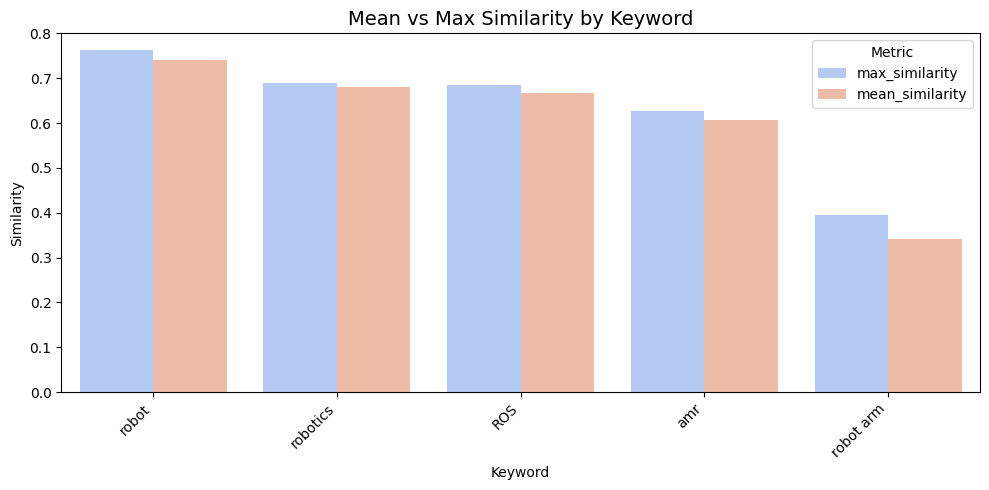

In [46]:
mean_sim = report_df.groupby("keyword")["similarity"].mean().rename("mean_similarity")
max_sim = report_df.groupby("keyword")["similarity"].max().rename("max_similarity")

# 2. Combine into one DataFrame
sim_df = pd.concat([mean_sim, max_sim], axis=1).reset_index()

# 3. Melt for seaborn hue plotting
sim_melted = sim_df.melt(id_vars="keyword", var_name="metric", value_name="similarity")

# 4. Plot with seaborn
plt.figure(figsize=(10, 5))
sns.barplot(
    data=sim_melted.sort_values("similarity", ascending=False),
    x="keyword",
    y="similarity",
    hue="metric",
    palette="coolwarm"
)
plt.title("Mean vs Max Similarity by Keyword", fontsize=14)
plt.xlabel("Keyword")
plt.ylabel("Similarity")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


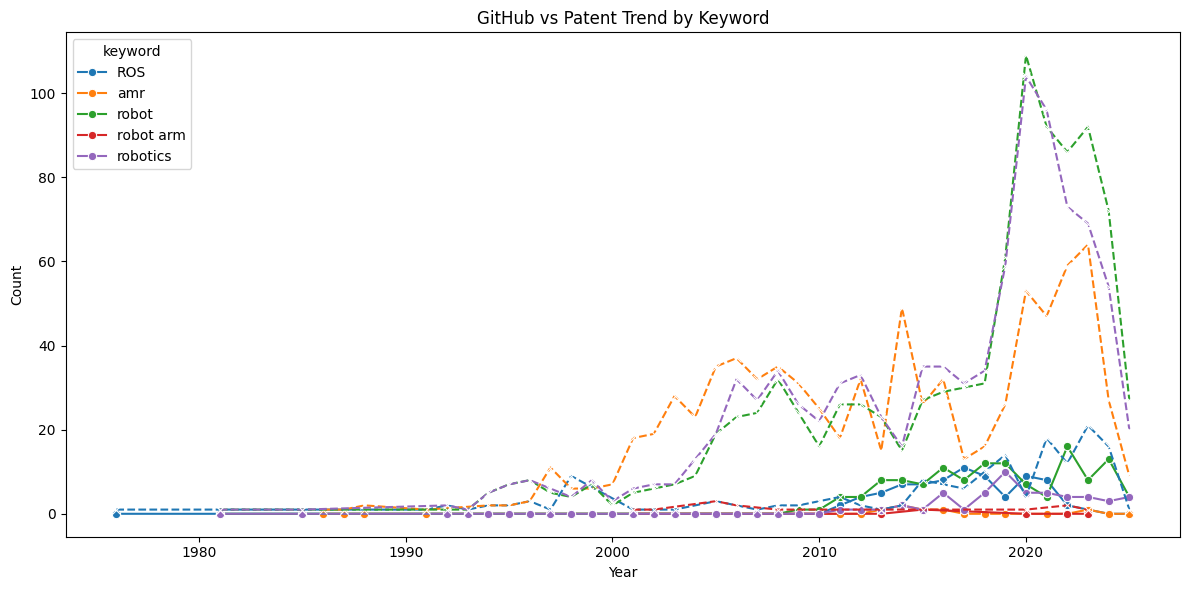

In [65]:
df_readme['year'] = pd.to_datetime(df_repos['created_at']).dt.year
df_kipris['year'] = pd.to_datetime(df_kipris['applicationDate']).dt.year

trend_read = df_readme.groupby(['keyword', 'year']).size().reset_index(name='count_readme')
trend_pat = df_kipris.groupby(['keyword', 'year']).size().reset_index(name='count_patent')

trend = pd.merge(trend_read, trend_pat, on=['keyword', 'year'], how='outer').fillna(0)

plt.figure(figsize=(12, 6))
sns.lineplot(data=trend, x="year", y="count_readme", hue="keyword", marker="o", palette="tab10")
sns.lineplot(data=trend, x="year", y="count_patent", hue="keyword", marker="x", linestyle="--", legend=False)
plt.title("GitHub vs Patent Trend by Keyword")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

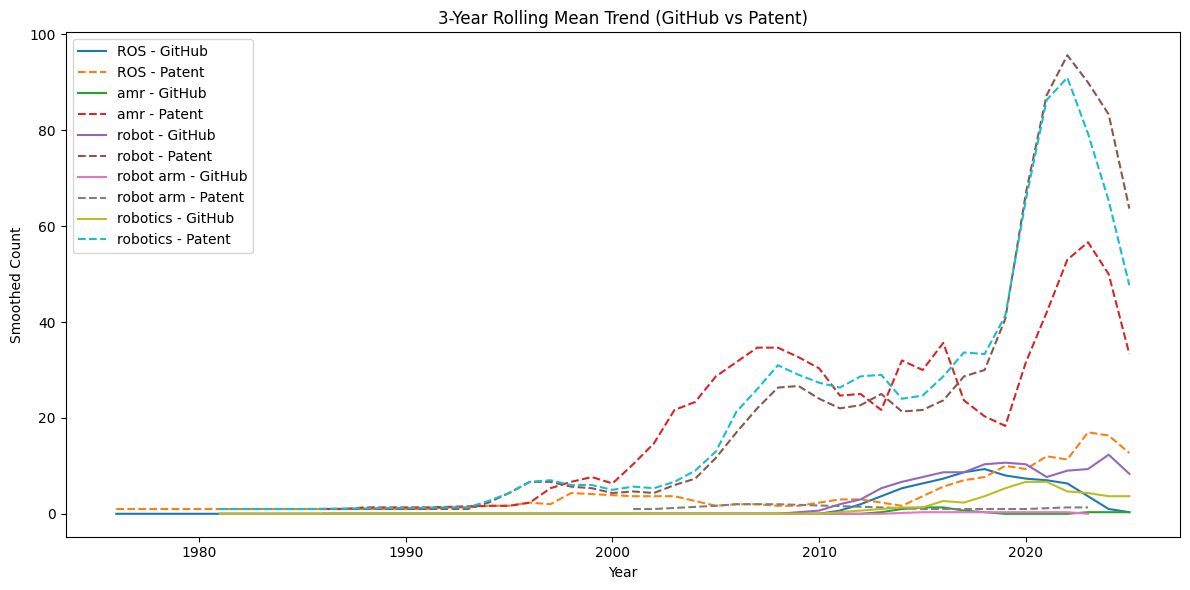

In [66]:
trend_smooth = trend.copy()
trend_smooth["readme_smooth"] = trend_smooth.groupby("keyword")["count_readme"].transform(lambda x: x.rolling(3, min_periods=1).mean())
trend_smooth["patent_smooth"] = trend_smooth.groupby("keyword")["count_patent"].transform(lambda x: x.rolling(3, min_periods=1).mean())

plt.figure(figsize=(12, 6))
for kw in trend_smooth["keyword"].unique():
    subset = trend_smooth[trend_smooth["keyword"] == kw]
    plt.plot(subset["year"], subset["readme_smooth"], label=f"{kw} - GitHub", linestyle="-")
    plt.plot(subset["year"], subset["patent_smooth"], label=f"{kw} - Patent", linestyle="--")
plt.title("3-Year Rolling Mean Trend (GitHub vs Patent)")
plt.xlabel("Year")
plt.ylabel("Smoothed Count")
plt.legend()
plt.tight_layout()
plt.show()

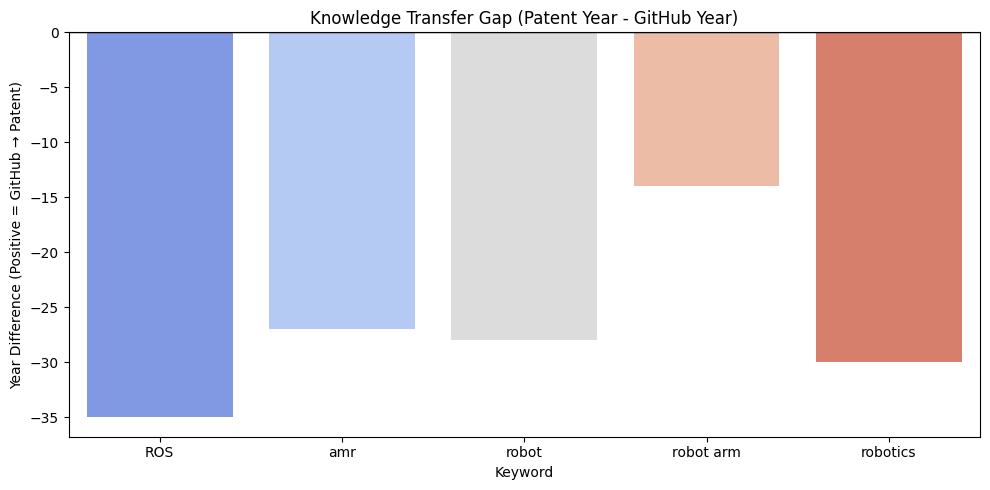

In [67]:
first_git = df_readme.groupby("keyword")["year"].min().rename("first_readme")
first_pat = df_kipris.groupby("keyword")["year"].min().rename("first_patent")

timing = pd.concat([first_git, first_pat], axis=1).dropna()
timing["gap"] = timing["first_patent"] - timing["first_readme"]

plt.figure(figsize=(10, 5))
sns.barplot(data=timing.reset_index(), x="keyword", y="gap", hue="keyword", palette="coolwarm")
plt.axhline(0, color="black", linewidth=1)
plt.title("Knowledge Transfer Gap (Patent Year - GitHub Year)")
plt.xlabel("Keyword")
plt.ylabel("Year Difference (Positive = GitHub ‚Üí Patent)")
plt.tight_layout()
plt.show()

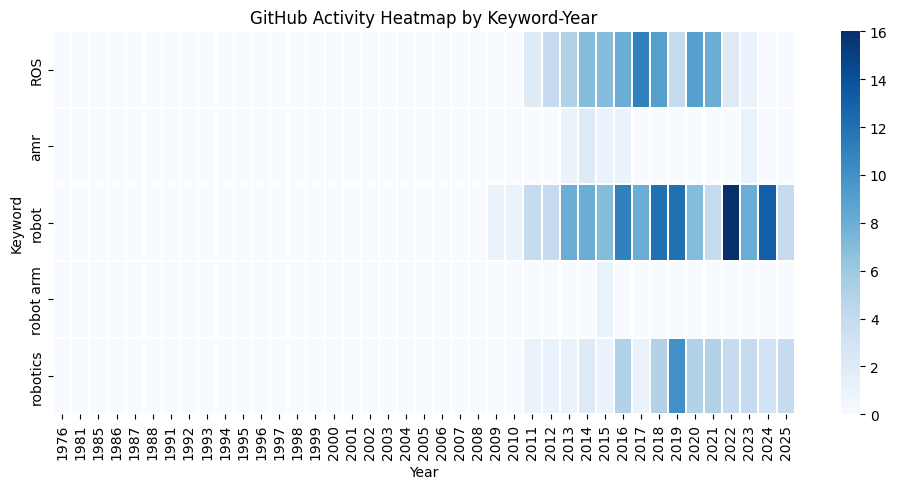

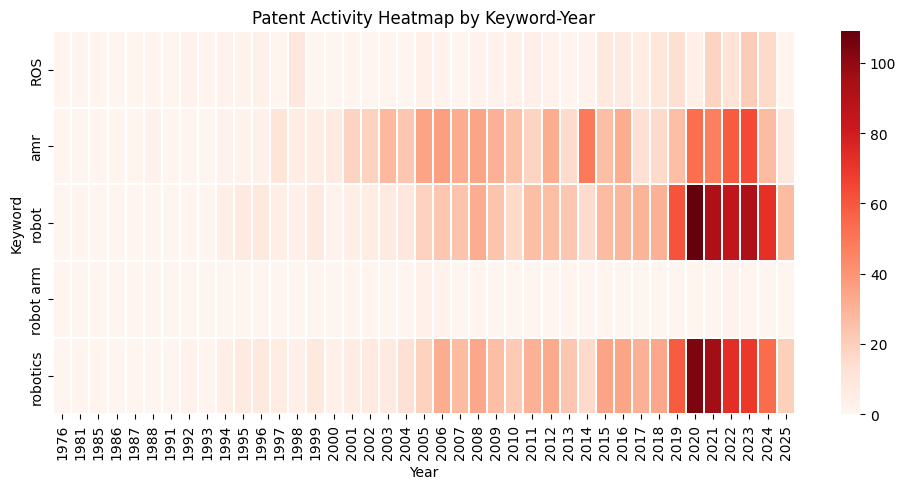

In [68]:
pivot_read = trend.pivot_table(index="keyword", columns="year", values="count_readme", fill_value=0)
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_read, cmap="Blues", linewidths=0.3)
plt.title("GitHub Activity Heatmap by Keyword-Year")
plt.xlabel("Year")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()

# Patent Heatmap
pivot_pat = trend.pivot_table(index="keyword", columns="year", values="count_patent", fill_value=0)
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_pat, cmap="Reds", linewidths=0.3)
plt.title("Patent Activity Heatmap by Keyword-Year")
plt.xlabel("Year")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()

In [69]:
keywords = ["ROS", "amr", "robot", "robot arm", "robotics"]
num_readme = [77, 6, 128, 1, 52]
num_patent = [166, 811, 952, 14, 952]

# Ï†ÑÏù¥ Ìö®Ïú® Í≥ÑÏÇ∞
transfer_efficiency = [p/r if r > 0 else 0 for p, r in zip(num_patent, num_readme)]

# 1Ô∏è‚É£ ÏÇ∞ÏóÖ Ï†ÑÏù¥ Í∞ïÎèÑ Í∏∞Î∞ò Sankey
fig1 = go.Figure(data=[go.Sankey(
    node=dict(
        label=keywords + ["Patent"],
        pad=15,
        thickness=20,
        color="lightgray"
    ),
    link=dict(
        source=list(range(len(keywords))),
        target=[len(keywords)] * len(keywords),
        value=num_patent,
        color="rgba(0,150,200,0.6)"
    )
)])
fig1.update_layout(title_text="GitHub ‚Üí Patent (by Patent Count)", font_size=12)
fig1.show()

# 2Ô∏è‚É£ ÏßÄÏãù Ï†ÑÏù¥ Ìö®Ïú® Í∏∞Î∞ò Sankey
fig2 = go.Figure(data=[go.Sankey(
    node=dict(
        label=keywords + ["Patent"],
        pad=15,
        thickness=20,
        color="lightgray"
    ),
    link=dict(
        source=list(range(len(keywords))),
        target=[len(keywords)] * len(keywords),
        value=transfer_efficiency,
        color="rgba(200,100,0,0.6)"
    )
)])
fig2.update_layout(title_text="GitHub ‚Üí Patent (by Transfer Efficiency: Patent/Readme)", font_size=12)
fig2.show()

In [71]:
patent_year_data = pd.DataFrame({
    "keyword": ["ROS", "ROS", "amr", "amr", "robot", "robotics", "robot arm", "robotics"],
    "year": [2020, 2023, 2021, 2024, 2019, 2022, 2023, 2024],
    "count": [40, 126, 210, 601, 350, 500, 14, 452]
})

# Ïó∞ÎèÑÎ≥Ñ ÎÖ∏Îìú ÏÉùÏÑ±
keywords = sorted(patent_year_data["keyword"].unique())
years = sorted(patent_year_data["year"].unique())
nodes = keywords + [f"Patent_{y}" for y in years]

# ÎÖ∏Îìú Ïù∏Îç±Ïä§ Îß§Ìïë
node_indices = {name: i for i, name in enumerate(nodes)}

# ÎßÅÌÅ¨ Ï†ïÎ≥¥ Íµ¨ÏÑ±
sources = []
targets = []
values = []

for _, row in patent_year_data.iterrows():
    src = node_indices[row["keyword"]]
    tgt = node_indices[f"Patent_{row['year']}"]
    sources.append(src)
    targets.append(tgt)
    values.append(row["count"])

# Sankey Í∑∏ÎûòÌîÑ ÏÉùÏÑ±
fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=nodes,
        pad=15,
        thickness=20,
        color="lightgray"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(0,150,200,0.6)"
    )
)])

fig.update_layout(
    title_text="Knowledge Transfer Flow (GitHub ‚Üí Patent by Year)",
    font_size=12,
    height=600
)
fig.show()

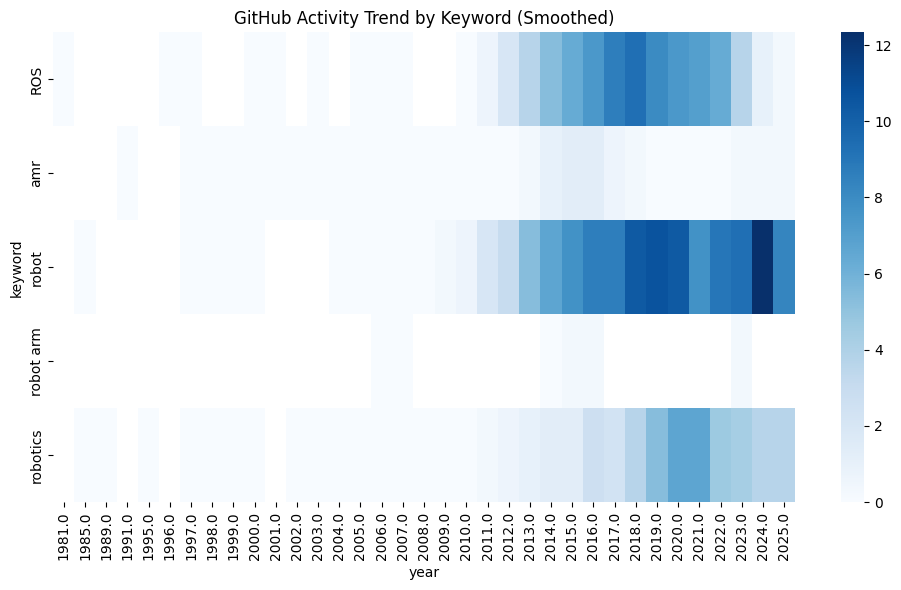

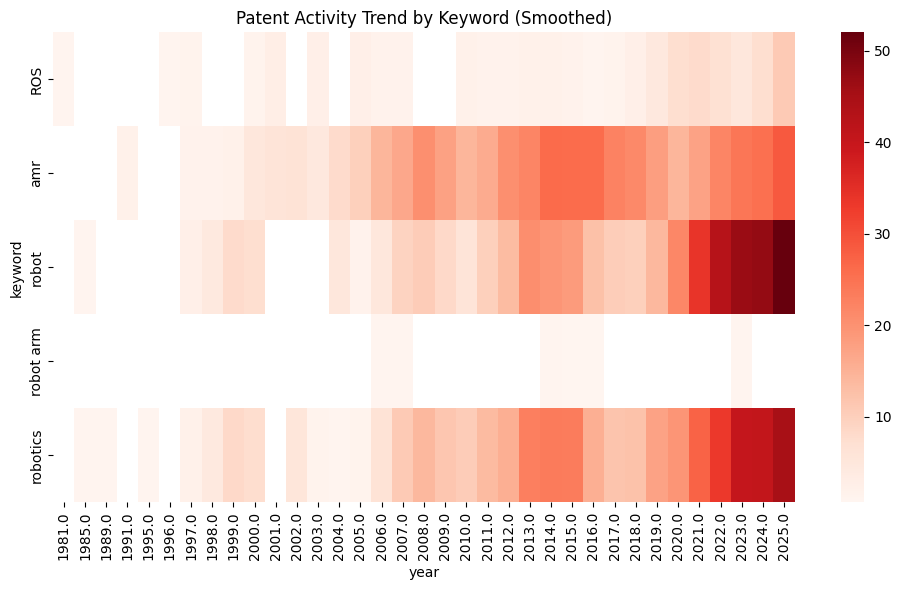

In [79]:
df_readme = pd.read_sql_table("github_readmes", con=engine)
df_kipris = pd.read_sql_table("kipris_patent", con=engine)
df_repos = pd.read_sql_table("github_repo", con=engine)


# 3Ô∏è‚É£ Ïó∞ÎèÑ Ïª¨Îüº Î≥ÄÌôò
df_repos["year"] = pd.to_datetime(df_repos["created_at"], errors="coerce").dt.year
df_kipris["year"] = pd.to_datetime(df_kipris["registerDate"], errors="coerce").dt.year

# 4Ô∏è‚É£ GitHub + Readme Í≤∞Ìï©
df_merged = pd.merge(df_repos, df_readme, on="full_name", how="inner")

# 5Ô∏è‚É£ ÌÇ§ÏõåÎìú Í∏∞Ï§ÄÏúºÎ°ú GitHub / Patent ÏßëÍ≥Ñ
repo_yearly = df_merged.groupby(["keyword", "year"]).size().reset_index(name="repo_count")
pat_yearly = df_kipris.groupby(["keyword", "year"]).size().reset_index(name="patent_count")

# 6Ô∏è‚É£ Í≤∞Ìï© Î∞è Ï†ïÎ¶¨
trend_df = pd.merge(repo_yearly, pat_yearly, on=["keyword", "year"], how="outer").fillna(0)

# 7Ô∏è‚É£ Rolling mean (3ÎÖÑ Ïù¥ÎèôÌèâÍ∑†)
trend_df["repo_smooth"] = trend_df.groupby("keyword")["repo_count"].transform(lambda x: x.rolling(3, min_periods=1).mean())
trend_df["pat_smooth"] = trend_df.groupby("keyword")["patent_count"].transform(lambda x: x.rolling(3, min_periods=1).mean())

# 8Ô∏è‚É£ Heatmap (Ïó∞ÎèÑÎ≥Ñ Ìä∏Î†åÎìú ÎπÑÍµê)
pivot = trend_df.pivot(index="keyword", columns="year", values="repo_smooth")
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="Blues", annot=False)
plt.title("GitHub Activity Trend by Keyword (Smoothed)")
plt.tight_layout()
plt.show()

pivot_pat = trend_df.pivot(index="keyword", columns="year", values="pat_smooth")
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_pat, cmap="Reds", annot=False)
plt.title("Patent Activity Trend by Keyword (Smoothed)")
plt.tight_layout()
plt.show()

## üß© 1Ô∏è‚É£ GitHub Activity Trend (ÏúÑÏ™Ω ÌååÎûÄ ÌûàÌä∏Îßµ)
Ï†ÑÎ∞òÏ†Å ÌäπÏßï
2010ÎÖÑ Ïù¥ÌõÑ Í∏âÍ≤©Ìïú Ï¶ùÍ∞Ä: ÎåÄÎ∂ÄÎ∂Ñ ÌÇ§ÏõåÎìúÍ∞Ä 2010ÎÖÑÎåÄ Ï§ëÎ∞òÎ∂ÄÌÑ∞ ÌôúÎèôÏù¥ Í∏âÏ¶ùÌï®.
robot / ROS Ï§ëÏã¨ Íµ¨Ï°∞
robot ÌÇ§ÏõåÎìú: GitHubÏóêÏÑú Í∞ÄÏû• ÌôúÎ∞úÌïú ÌôúÎèô. 2014~2020ÎÖÑÎåÄÏóê ÏßëÏ§ëÏ†ÅÏúºÎ°ú Ï¶ùÍ∞Ä.
ROS: 2015~2019ÎÖÑÎåÄÏóê ÌîºÌÅ¨ ‚Üí Ïù¥ÌõÑ Ï†êÏ∞® Í∞êÏÜå.
robotics: robotÍ≥º Ïú†ÏÇ¨Ìïú ÏãúÍ∏∞(2014~2019)Ïóê Ï¶ùÍ∞ÄÌïòÏßÄÎßå Í∑úÎ™®Îäî Îã§ÏÜå ÏûëÏùå.
amr / robot arm: ÌôúÎèôÎüâÏù¥ Ï†ÅÏßÄÎßå, 2018ÎÖÑ Ïù¥ÌõÑ ÏôÑÎßåÌïú Ï¶ùÍ∞ÄÏÑ∏.

## ÏöîÏïΩ
2010ÎÖÑÎåÄ Ï§ëÎ∞òÏùÑ Í∏∞Ï†êÏúºÎ°ú Î°úÎ¥á Í¥ÄÎ†® Ïò§ÌîàÏÜåÏä§ ÌîÑÎ°úÏ†ùÌä∏Í∞Ä Î≥∏Í≤©ÌôîÎêòÏóàÍ≥†,
ÌäπÌûà robot, ROS, robotics Î∂ÑÏïºÍ∞Ä Ï§ëÏã¨Ï†ÅÏù∏ Í∏∞Ïà† ÌóàÎ∏å Ïó≠Ìï†ÏùÑ Ìï®.

## üî¨ 2Ô∏è‚É£ Patent Activity Trend (ÏïÑÎûòÏ™Ω Îπ®Í∞Ñ ÌûàÌä∏Îßµ)
Ï†ÑÎ∞òÏ†Å ÌäπÏßï
1990~2000ÎÖÑÎåÄ Ï¥àÎ∞òÏóêÎèÑ ÌôúÎèô Ï°¥Ïû¨: GitHubÎ≥¥Îã§ ÏïΩ 10~20ÎÖÑ ÏïûÏÑúÏÑú Í∏∞Ïà†Í∞úÎ∞úÏù¥ ÏãúÏûëÎê®.
2010ÎÖÑ Ïù¥ÌõÑ ÌäπÌóà ÏßëÏ§ëÎèÑ Í∏âÏÉÅÏäπ:
robotÍ≥º roboticsÎäî 2015ÎÖÑ Ïù¥ÌõÑ Í∏âÍ≤©Ìûà Ï¶ùÍ∞ÄÌïòÎ©∞ 2020ÎÖÑÎåÄ ÌîºÌÅ¨.
amrÏùÄ ÎπÑÍµêÏ†Å ÏùºÏ∞ç(2005ÎÖÑÎåÄ Ï¥àÏ§ëÎ∞ò) Îì±Ïû•, 2015~2020ÎÖÑÎåÄ Ìè≠Î∞úÏ†Å ÏÑ±Ïû•.
ROSÎäî 2015ÎÖÑÎåÄ Ïù¥ÌõÑÏóêÎßå ÎààÏóê ÎùÑÎäî Ï¶ùÍ∞Ä.
robot armÏùÄ ÏÜåÍ∑úÎ™®ÏßÄÎßå Íæ∏Ï§ÄÌïú Ï¶ùÍ∞ÄÏÑ∏.

## ÏöîÏïΩ

ÏÇ∞ÏóÖÍ≥ÑÏóêÏÑúÎäî Î°úÎ¥á Î∞è AMR Í¥ÄÎ†® Í∏∞Ïà†Ïù¥ GitHubÎ≥¥Îã§ Ìõ®Ïî¨ Ïù¥Î•∏ ÏãúÏ†êÎ∂ÄÌÑ∞ Ïó∞Íµ¨ÎêòÏñ¥ ÏôîÏúºÎ©∞,
GitHub Ïò§ÌîàÏÜåÏä§Í∞Ä ÌôúÏÑ±ÌôîÎêú Ïù¥ÌõÑ(2015ÎÖÑÎåÄ ÌõÑÎ∞ò)ÏóêÎäî ÌäπÌóà Ï∂úÏõêÏù¥ ÎçîÏö± Í∞ÄÏÜçÌôîÎê®.

## ÏßÄÏãùÏ†ÑÏù¥(knowledge diffusion) ÏãúÏ∞®
GitHub ÌôúÎèôÏù¥ Ï¶ùÍ∞ÄÌïú Îí§ ÏïΩ 2~4ÎÖÑ ÌõÑÏóê ÌäπÌóà Îì±Î°ùÏù¥ Í∏âÏ¶ùÌï®.
‚Üí Ï¶â, **Ïò§ÌîàÏÜåÏä§ Í∏∞Ïà†Ïù¥ ÏÇ∞ÏóÖÌôîÎêòÎäî ÏãúÍ∞ÑÏßÄÏó∞(Lag)**Ïù¥ ÏïΩ 3ÎÖÑ ÏàòÏ§Ä.
Ïò§ÌîàÏÜåÏä§ Í∏∞Î∞ò Í∏∞Ïà† ÏÇ∞ÏóÖÌôî Íµ¨Ï°∞
ROS, robotics ‚Üí ÌëúÏ§ÄÌôî¬∑Í≥µÏú† Ï§ëÏã¨ Í∏∞Ïà†
amr, robot arm ‚Üí ÏùëÏö©¬∑ÌòÑÏû• ÏûêÎèôÌôî Ï§ëÏã¨ Í∏∞Ïà†
Îëê Í∑∏Î£πÏù¥ ÏÉÅÌò∏Î≥¥ÏôÑÏ†ÅÏúºÎ°ú ÏûëÎèôÌïòÎ©∞ Í∏∞Ïà† ÏÉùÌÉúÍ≥ÑÎ•º ÌòïÏÑ±.
Í∏∞Ïà† ÌùêÎ¶ÑÏùò ÏßÑÌôî Î∞©Ìñ•
Ï¥àÍ∏∞(2000~2010): ÏÇ∞ÏóÖ Í∏∞Ïà† Ï§ëÏã¨ (ÌäπÌóà ÏÑ†Ìñâ)
Ï§ëÍ∏∞(2010~2018): GitHub Ï§ëÏã¨ Ïª§ÎÆ§ÎãàÌã∞ ÌôïÏÇ∞
ÏµúÍ∑º(2018~2025): GitHub Í∏∞Ïà†Ïù¥ ÏÇ∞ÏóÖÏóê Îπ†Î•¥Í≤å Ïù¥Ï†Ñ (ÏßÄÏãù Ï†ÑÏù¥ Í∞ÄÏÜçÌôî)

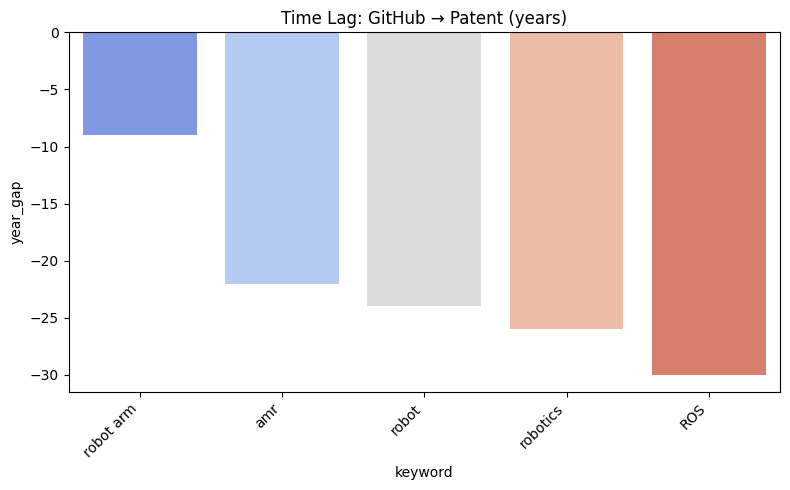

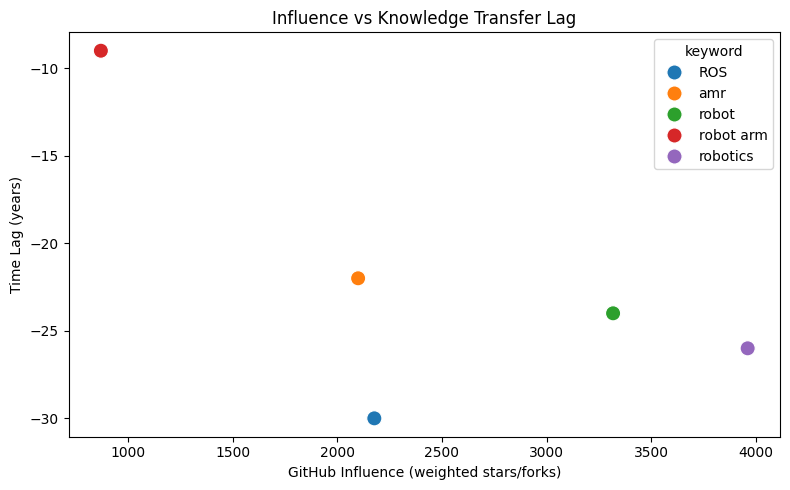

In [77]:
repo_stats = (
    df_merged.groupby("keyword")
    .agg(
        repo_year=("year", "min"),
        mean_stars=("stars", "mean"),
        mean_forks=("forks", "mean")
    )
    .reset_index()
)

# 6Ô∏è‚É£ ÌäπÌóà Ïó∞ÎèÑ Í≥ÑÏÇ∞
pat_stats = (
    df_kipris.groupby("keyword")
    .agg(patent_year=("year", "min"))
    .reset_index()
)

# 7Ô∏è‚É£ Í≤∞Ìï© ‚Üí ÏßÄÏó∞ Í≥ÑÏÇ∞
trend = pd.merge(repo_stats, pat_stats, on="keyword", how="inner")
trend["year_gap"] = trend["patent_year"] - trend["repo_year"]

# 8Ô∏è‚É£ ÏòÅÌñ•Î†• Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞
trend["influence"] = (trend["mean_stars"] * 0.7) + (trend["mean_forks"] * 0.3)

# 9Ô∏è‚É£ ÏãúÍ∞ÅÌôî: Ïó∞ÎèÑ ÏßÄÏó∞
plt.figure(figsize=(8, 5))
sns.barplot(data=trend.sort_values("year_gap", ascending=False), x="keyword", y="year_gap", hue="keyword", palette="coolwarm")
plt.title("Time Lag: GitHub ‚Üí Patent (years)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# üîü ÏãúÍ∞ÅÌôî: ÏòÅÌñ•Î†• vs ÌäπÌóàÌôî ÏãúÍ∏∞
plt.figure(figsize=(8, 5))
sns.scatterplot(data=trend, x="influence", y="year_gap", hue="keyword", s=120)
plt.title("Influence vs Knowledge Transfer Lag")
plt.xlabel("GitHub Influence (weighted stars/forks)")
plt.ylabel("Time Lag (years)")
plt.tight_layout()
plt.show()

## Time Lag (Ïó∞ÎèÑ ÏßÄÏó∞)
‚Üí year_gapÏù¥ ÏûëÏùÑÏàòÎ°ù GitHubÏóêÏÑú Í≥µÍ∞úÎêú Í∏∞Ïà†Ïù¥ Îπ†Î•¥Í≤å ÏÇ∞ÏóÖÌôî(ÌäπÌóàÌôî)Îêú Í≤É

‚Üí robotics, ROS Í∞ôÏùÄ ÌÇ§ÏõåÎìúÎäî ÏùºÎ∞òÏ†ÅÏúºÎ°ú ÏßßÏùÄ ÏßÄÏó∞ (Ï¶âÏãú ÌôúÏö© Í∞ÄÎä• Í∏∞Ïà†) 
 
## Influence vs Lag
‚Üí ÏòÅÌñ•Î†•(stars, forks)Ïù¥ ÌÅ∞ ÌîÑÎ°úÏ†ùÌä∏ÏùºÏàòÎ°ù ÏßÄÏó∞Ïù¥ ÏßßÎã§Î©¥

‚Üí Ïò§ÌîàÏÜåÏä§ Ïª§ÎÆ§ÎãàÌã∞ÏóêÏÑú ÏÇ∞ÏóÖÏúºÎ°úÏùò ÏßÄÏãù ÌôïÏÇ∞ ÏÜçÎèÑÍ∞Ä Îπ†Î¶Ñ

‚Üí Î∞òÎåÄÎ°ú ÏòÅÌñ•Î†•Ïù¥ Ïª§ÎèÑ ÏßÄÏó∞Ïù¥ Í∏∏Îã§Î©¥

‚Üí ÏÇ∞ÏóÖ Ï†ÅÏö©Ïóê ÏãúÍ∞ÑÏù¥ ÌïÑÏöîÌïú Î≥µÏû° Í∏∞Ïà†Íµ∞Ïùº Í∞ÄÎä•ÏÑ±